In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/SoftCom/training-a'
a_csv = pd.read_csv('drive/My Drive/SoftCom/training-a.csv',low_memory=False)


Mounted at /content/drive


In [3]:
#a_csv = pd.read_csv('/content/drive/MyDrive/SoftCom/training-a.csv')
a_csv.columns
a_csv = a_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
a_csv.iloc[:10, 0:]

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
5,a00005.png,4
6,a00006.png,3
7,a00007.png,0
8,a00008.png,4
9,a00009.png,9


In [4]:
label_csv = a_csv

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [6]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(180),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(label_csv, path, train_transform)
test_data = Dataset(label_csv, path, test_transform)

print("Trainig Samples: ",len(train_data))


Trainig Samples:  19702


In [7]:
batch_size = 20
num_iters = 20000
input_dim = 180*180 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [10]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_6 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss=[] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. \n Loss: {}.\n  Accuracy: {}\n'.format(iter, loss.item(), accuracy))

Iteration: 500. 
 Loss: 2.3098137378692627.
  Accuracy: 10.070043650390824

Iteration: 1000. 
 Loss: 2.3016014099121094.
  Accuracy: 10.070043650390824

Iteration: 1500. 
 Loss: 2.303007125854492.
  Accuracy: 11.856664298040808

Iteration: 2000. 
 Loss: 2.300422191619873.
  Accuracy: 10.070043650390824

Iteration: 2500. 
 Loss: 2.2916011810302734.
  Accuracy: 9.968531113592528

Iteration: 3000. 
 Loss: 2.2908356189727783.
  Accuracy: 9.897472337833722

Iteration: 3500. 
 Loss: 2.299548625946045.
  Accuracy: 9.897472337833722

Iteration: 4000. 
 Loss: 2.2390685081481934.
  Accuracy: 10.070043650390824

Iteration: 4500. 
 Loss: 2.28076171875.
  Accuracy: 10.105573038270226

Iteration: 5000. 
 Loss: 2.0849039554595947.
  Accuracy: 10.125875545629885

Iteration: 5500. 
 Loss: 2.0536136627197266.
  Accuracy: 10.32382499238656

Iteration: 6000. 
 Loss: 2.257349967956543.
  Accuracy: 9.968531113592528

Iteration: 6500. 
 Loss: 2.103316068649292.
  Accuracy: 9.93807735255304

Iteration: 7000. 

[2.3098137378692627, 2.3016014099121094, 2.303007125854492, 2.300422191619873, 2.2916011810302734, 2.2908356189727783, 2.299548625946045, 2.2390685081481934, 2.28076171875, 2.0849039554595947, 2.0536136627197266, 2.257349967956543, 2.103316068649292, 2.195817470550537, 2.1427276134490967, 2.062945604324341, 1.7578201293945312, 1.8517110347747803, 1.8458799123764038, 1.7904402017593384, 1.7875521183013916, 1.9597845077514648, 1.725604772567749, 2.278322696685791, 1.726496696472168, 1.7977206707000732, 1.7298482656478882, 1.7084983587265015, 1.8223447799682617, 1.7828891277313232, 1.9029741287231445, 1.9991194009780884, 1.9220924377441406, 1.838366150856018, 1.5692193508148193, 2.037395715713501, 1.8010120391845703, 2.064884662628174, 1.926088571548462]


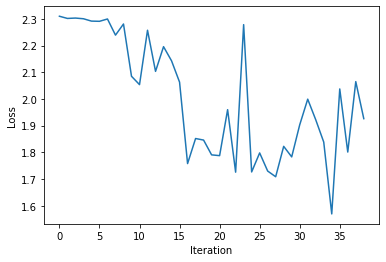

In [11]:
import matplotlib.pyplot as plt
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()
